In [18]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

from google.colab import widgets
import os
import argparse
from torch import LongTensor, FloatTensor
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import pandas as pd
from torch.nn.utils.rnn import PackedSequence, pad_packed_sequence, pack_padded_sequence, pack_sequence, pad_sequence

import re
import string
import unicodedata 
import os
import codecs
import random
import logging
import json
import itertools
import math
import copy
import numpy as np
import time
import sys
import gc
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from collections import Counter, defaultdict
from easydict import EasyDict as edict

%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

path_to_folder = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [0]:
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
    
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value

In [0]:
import numpy as np
from typing import Sequence

data_dir = '/content/gdrive/My Drive/85_76'

def load_data(which: str):
    """
    Loads data from a csv file
    :param which: str
        Which data to load, train or test
    """
    assert which in ['train', 'test']
    
    if which == 'train':
        data = np.loadtxt(fname=os.path.join(data_dir, 'train_data.csv'), delimiter=',', skiprows=1)
        labels = np.loadtxt(fname=os.path.join(data_dir, 'train_labels.csv'), delimiter=',', skiprows=1)
        return data, labels
    elif which == 'test':
        data = np.loadtxt(fname=os.path.join(data_dir, 'test_data.csv'), delimiter=',', skiprows=1)
        return data
    
def save_prediction(prediction: Sequence[int], 
                    path: str = 'submission.csv'):
    """
    Saves a sequence of predictions into a csv file with additional index column
    :param prediction: Sequence of ints
        Predictions to save
    :param path: str
        Path to a file to save into
    """
    
    pred_with_id = np.stack([np.arange(len(prediction)), prediction], axis=1)
    np.savetxt(fname=path, X=pred_with_id, fmt='%d', delimiter=',', header='id,label', comments='')

In [21]:
train_data, train_labels = load_data(which='train')
print(train_data.shape)
print(train_labels.shape)

torch.manual_seed(7)

indices=torch.randperm(train_data.shape[0])
train_data = train_data[indices, :]
train_labels = train_labels[indices]

(59580, 342)
(59580,)


In [22]:
to_valid = 400
to_test = 2000
final_valid, final_labels = train_data[:to_valid], train_labels[:to_valid]
all_train, all_labels = train_data[to_valid:], train_labels[to_valid:]
d_train, t_labels = all_train[to_test:], all_labels[to_test:]
d_valid, v_labels = all_train[:to_test], all_labels[:to_test]

print(np.bincount(np.array(t_labels).astype(int)))
print(np.bincount(np.array(v_labels).astype(int)))
print(d_valid.shape)
print(d_train.shape)
print(all_train.shape)
print(final_valid.shape)

train = [(torch.Tensor(d_train[i]), int(t_labels[i])) for i in range(d_train.shape[0])]
valid_1 = [(torch.Tensor(d_valid[i]), int(v_labels[i])) for i in range(d_valid.shape[0])]

valid_2 = [(torch.Tensor(final_valid[i]), int(final_labels[i])) for i in range(final_valid.shape[0])]
whole_train = [(torch.Tensor(all_train[i]), int(all_labels[i])) for i in range(all_train.shape[0])]

print(len(whole_train))

[5714 5738 5709 5723 5729 5710 5698 5710 5747 5702]
[206 181 211 207 188 208 211 205 172 211]
(2000, 342)
(57180, 342)
(59180, 342)
(400, 342)
59180


In [0]:
saved_model = '/content/gdrive/My Drive/85_76/weights.pkl'

def save_checkpoint(optimizer, model, accuracy, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'accuracy': accuracy
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    accuracy = checkpoint_dict['accuracy']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

def draw(losses, title, lab):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, losses, '-o', label=lab)
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.show()

def draw_losses(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_losses, '-o', label='Training loss')
    plt.plot(epochs, test_losses, '-o', label='Validation loss')
    plt.legend()
    plt.title('Learning curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.show()

In [0]:
class TorchNetwork(torch.nn.Module):
    def __init__(self, batch_size, input_dim, hidd1, hidd2, hidd3, output_dim):
        super(TorchNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidd1),
            nn.BatchNorm1d(hidd1),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidd1, hidd2),
            nn.BatchNorm1d(hidd2),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidd2, hidd3),
            nn.BatchNorm1d(hidd3),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        self.final = nn.Linear(hidd3, output_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return self.final(x)

EPOCH 0

Training accuracy: 0.7572053165442463

Test accuracy: 0.817
EPOCH 1

Training accuracy: 0.8088142707240293

Test accuracy: 0.834
EPOCH 2

Training accuracy: 0.8253934942287513

Test accuracy: 0.842
EPOCH 3

Training accuracy: 0.8362889122070654

Test accuracy: 0.8625
EPOCH 4

Training accuracy: 0.8466596712137111

Test accuracy: 0.8535
EPOCH 5

Training accuracy: 0.869552291010843

Test accuracy: 0.861
EPOCH 6

Training accuracy: 0.8779993004547044

Test accuracy: 0.867
EPOCH 7

Training accuracy: 0.8826162994053866

Test accuracy: 0.8665
EPOCH 8

Training accuracy: 0.8863413781042323

Test accuracy: 0.866
EPOCH 9

Training accuracy: 0.8934767401189228

Test accuracy: 0.867
EPOCH 10

Training accuracy: 0.8925848198670864

Test accuracy: 0.867
EPOCH 11

Training accuracy: 0.8952605806225953

Test accuracy: 0.8685
EPOCH 12

Training accuracy: 0.8944735921650927

Test accuracy: 0.87
EPOCH 13

Training accuracy: 0.8980762504372158

Test accuracy: 0.8675
EPOCH 14

Training accuracy

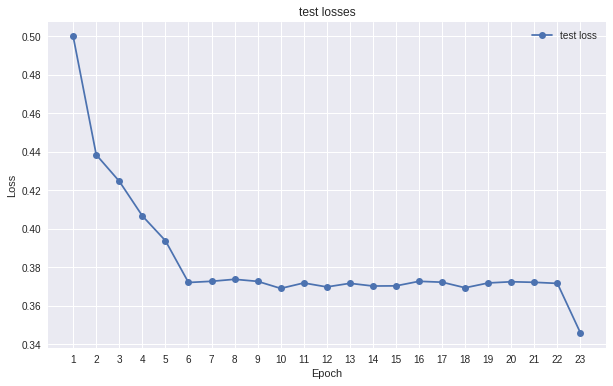

In [25]:
from torch.optim import SGD
from torch.nn.functional import cross_entropy

batch_size: int = 64
epoch: int = 22
lr: float = 0.001
momentum: float = 0.9
hidd1: int = 1700
hidd2: int = 1100
hidd3: int = 550
input_dim: int = 342
output_dim: int = 10
clip = 0.5

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(valid_1, batch_size=batch_size)
final_valid_loader = torch.utils.data.DataLoader(valid_2, batch_size=batch_size)

model: TorchNetwork = TorchNetwork(batch_size, input_dim, hidd1, hidd2, hidd3, output_dim)
optimizer: torch.optim.Optimizer = optim.Adam(model.parameters(), lr)#, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2)
best_accuracy = 0.0
test_losses, losses = [], []

model.cuda()

def train_epoch():
    model.train()
    correct_train = 0
    tr_loss = RunningAverage()
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = x.cuda(), y.cuda()
        output: torch.Tensor = model(x)
        correct_in_batch = (torch.max(output, 1)[1].view(y.shape[0]) == y).sum().item()
        correct_train += correct_in_batch
        loss: torch.Tensor = cross_entropy(output, y)
        loss.backward()
        tr_loss.update(loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)        
        optimizer.step()
    
    losses.append(tr_loss.value)
    print(f"\nTraining accuracy: {correct_train / len(train)}")

    
def test_epoch(data_loader, valid, best_accuracy):
    model.eval()
    with torch.no_grad():
        correct: int = 0
        test_loss = RunningAverage()
        for i, (x, y) in enumerate(data_loader):
            x, y = x.cuda(), y.cuda()
            output: torch.Tensor = model(x)
            correct += (torch.max(output, 1)[1].view(y.shape[0]) == y).sum().item()
            loss = cross_entropy(output, y)
            test_loss.update(loss)
                
        test_losses.append(test_loss.value)
            
        accuracy = correct / len(valid)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_checkpoint(optimizer, model, accuracy, saved_model)
        print(f"\nTest accuracy: {correct / len(valid)}")
    return best_accuracy


best_accuracy = 0
for e in range(epoch):
    print(f"EPOCH {e}")
    train_epoch()
    best_accuracy = test_epoch(test_loader, valid_1, best_accuracy)
    scheduler.step()
    

print(f"BEST ACCURACY IS {best_accuracy}")

print("VALID TEST PRETRAINING")
_ = test_epoch(final_valid_loader, valid_2, best_accuracy)

draw(losses, 'training losses', 'training loss')
draw(test_losses, 'test losses', 'test loss')

In [26]:
# zapisane wagi modelu, ktory osiagnal najwyzszy wynik na kagglu
# z jakiegos powodu ten samel model nie odtwarza identycznego wyniku, a minimalnie slabszy, mimo ustawionego seeda
best_model = '/content/gdrive/My Drive/85_76/best_weights.pkl'
load_checkpoint(optimizer, model, best_model)
best_accuracy = test_epoch(test_loader, valid_1, best_accuracy)


Test accuracy: 0.873


In [27]:
test_data = load_data(which='test')
load_checkpoint(optimizer, model, best_model)

preds = torch.Tensor([])
preds = preds.cuda()
nr_batches = test_data.shape[0] // batch_size

with torch.no_grad():
    for i in range(nr_batches):
        batch = torch.Tensor(test_data[i*batch_size:(i+1)*batch_size])
        #batch_predictions: torch.Tensor = model(batch)
        batch = batch.cuda()
        batch_predictions = model(batch)
        preds = torch.cat((preds, batch_predictions), 0)
        
        
    batch = torch.Tensor(test_data[nr_batches*batch_size:])
    batch = batch.cuda()
    remaining_examples = test_data.shape[0] - nr_batches*batch_size
    #batch_predictions: torch.Tensor = model(batch)
    batch_predictions = model(batch)
    preds = torch.cat((preds, batch_predictions[:remaining_examples]), 0)

final_predictions = torch.argmax(preds, dim=1)
print(final_predictions.shape)
save_prediction(prediction=final_predictions.cpu(), path=os.path.join(data_dir, 'submission.csv'))

torch.Size([10000])
